# A False Color Map of the 2017 Thomas Fire

Author: Stephen Carroll

This project repository can be found at: [https://github.com/stephenccodes/eds220-hwk4](https://github.com/stephenccodes/eds220-hwk4)

## <ins>About</ins>
### Purpose:

The intent of this notebook is to use remote sensing and fire perimeter data to create a false-color map of the 2017 Thomas Fire and the surrounding area. The map will indicate the extent of the fire scar, and highlight areas that contain vegetation or bare soil with colors that have more contrast than a true color image. This will be achieved through various data analysis techniques and iterations of plots, outlined below.

### Highlights:

- Import, clean, and manipulate an xarray dataset
- Create a set of plots of the area in true and false-color without creating new variables
- Remove outlier values by adjusting the scale with the `robust` parameter.
- Import existing geo-data frame and implement it
- Create a polished map of the false-color image, with superimposed fire perimeter

### Data Description:
####  <ins>Landsat Collection 2 Level-2</ins>

 This data is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite.
The data was retrieved from the Microsof Planetary Computer data catalogue and pre-processed to remove data outside land and coarsen the spatial resolution.

Date accessed: 11/19/24

Original data source:

[https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)

#### <ins>California Fire Perimeters</ins>

This database contains information about spatial distribution of historic wild and prescribed fires in the state of California. The data comes with a warning that it is not comprehensive, with some records lost or damaged, fire perimeters may be missing. There may also be duplicate fires and over-generalization of fire perimeters. The database is maintained by the California Department of Forestry and Fire Protection’s Fire and Resource Assessment Program.

Date accessed: 11/19/24

Original data source:

https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436

**Reference List:**

1. U.S. Geological Survey. (n.d.). *Landsat 8-9 OLI/TIRS collection 2 level-2 science products | USGS EROS Archive*. U.S. Geological Survey. https://www.usgs.gov/centers/eros/science/usgs-eros-archive-landsat-archives-landsat-8-9-olitirs-collection-2-level-2 Access date: November 19, 2024.

2. Data.gov. (2024). *California fire perimeters (ALL)*. Data.gov. https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436 Access date: November 19, 2024.

### **True Color Image**

#### Construct a file path to the Landsat data and import it

In [13]:
# Import libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

# Establish a file path for the landsat data
fp = os.path.join('data/landsat8-2018-01-26-sb-simplified.nc')

# Import the landsat data
landsat = rioxr.open_rasterio(fp)

####  Data Exploration

In [14]:
# View the data
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

In [15]:
# Find the CRS of the landsat data
print('CRS', landsat.rio.crs)

CRS EPSG:32611


In [16]:
# Find the dimensions of the landsat data
print('Height: ', landsat.rio.height)
print('Width: ', landsat.rio.width)

Height:  731
Width:  870


In [17]:
# Find the data type of the landsat data
print('Data type: \n', landsat.dtypes)

Data type: 
 Frozen({'red': dtype('float64'), 'green': dtype('float64'), 'blue': dtype('float64'), 'nir08': dtype('float64'), 'swir22': dtype('float64')})


In [18]:
# Find the geographic extent of the landsat data
print(landsat.rio.bounds(), '\n')

(121170.0, 3755160.0, 356070.0, 3952530.0) 



#### Data Exploration Summary:

To begin, I viewed the landsat data to learn more about it. It has the variables 'Red', 'Green', 'Blue', 'nir08', and 'swir12'. These variables represent energy bands, and the last two variables have unique names but are assumed to represent near-infrared and short wave infrared bands. I found the coordinate reference system(CRS) used and printed the height(731) and width(870) of the dataset. I listed the data types for each variable, as well as the geographic boundary of the data.

#### Drop the `band` dimension of the data:

In [19]:
# Remove the first dimension(band) and drop the associated coordinates
landsat = landsat.squeeze().drop_vars('band')

#### Select the red, green, and blue variables and convert it to an array and plot it:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


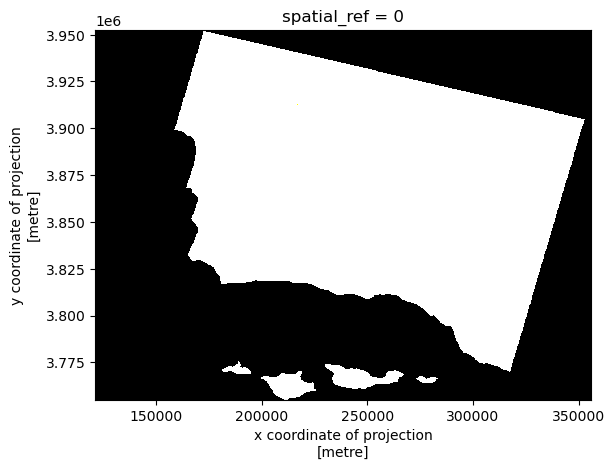

In [20]:
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

#### Adjust the scale used for plotting the bands to get a true color image and plot it again:

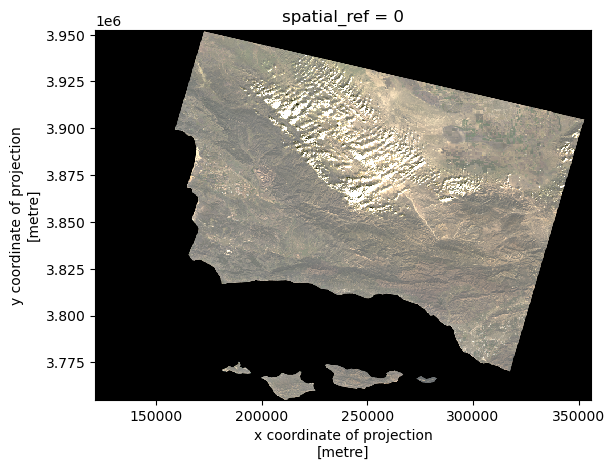

In [21]:
# Remove the exterem values caused by cloud cover and plot it again
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)

#### Comparison of the ouputs for these first two maps:

The first plot displays all of the values present, including extreme values caused by clouds or other interference. These extreme values affect the color scale, with most values rendering as either black or white. The second plot is adjusted to avoid the influence of these extreme values. When you set `robust = True`, the only values displayed are from the 2nd to 98th percentiles, allowing the color scale to better represent the meaningful range of values.  

### **False color image**

#### Plot the short-wave infrared(swir22), near-infrared(nir08, and red variables:

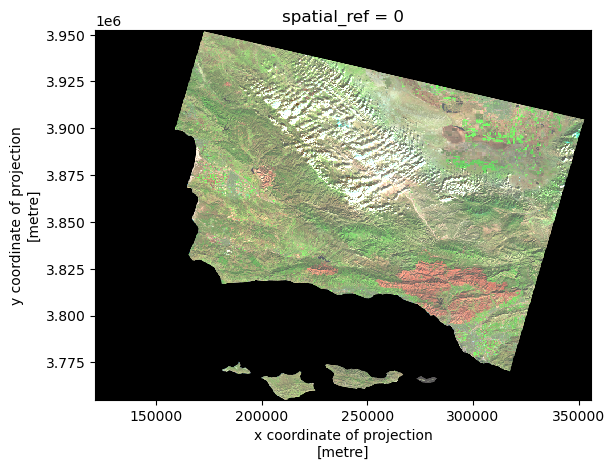

In [22]:
# Use SWIR, NIR, and Red wavelengths to viaulize the vegetation and burn areas better
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

### **False Color Composite Map**


#### Import Thomas Fire perimeter and convert the CRS to match Landsat data:

In [23]:
# Read in the Thomas fire data and convert CRS to match the landsat data
thomas_fire = gpd.read_file('data/thomas_fire/thomas_fire.shp').to_crs(landsat.rio.crs)

# Confirm the change was successful
assert landsat.rio.crs == thomas_fire.crs

#### Combine both elements to create a compostie map:

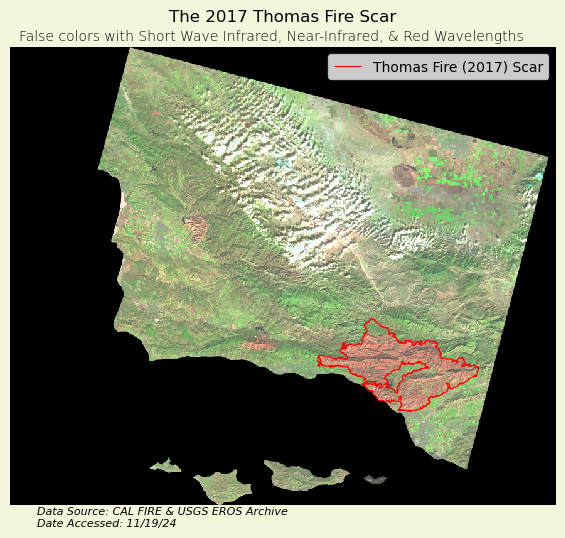

In [24]:
# Define the landsat aspect ratio
landsat_aspect_ratio = landsat.rio.width / landsat.rio.height 

# Initialize the figure and set the dimensions
fig, ax = plt.subplots(figsize = (9, 5 * landsat_aspect_ratio)) # Apply the aspect ratio

# Set the background color of the entire figure 
fig.patch.set_facecolor('beige')

# Remove axes for cleaner map
ax.axis('off') 

# Plot the false color remorte sensing data
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax = ax)

# Plot the Thomas Fire perimeter
thomas_fire.boundary.plot(ax = ax, 
                          color = "red", # Color it red for emphasis
                          linewidth = 0.8)

# Add a main title
ax.set_title("The 2017 Thomas Fire Scar\n", fontsize = 12)

# Add subtitle describing the false colors
fig.suptitle("False colors with Short Wave Infrared, Near-Infrared, & Red Wavelengths", 
             color = 'black', 
             fontsize = 10, 
             fontweight='light', 
             y=0.91)

# Add a legend for the fire boundary
ax.legend(labels = ['Thomas Fire (2017) Scar'])

# Add a footnote citation at the bottom of the figure
fig.text(0.379, 0.1, # Position
         'Data Source: CAL FIRE & USGS EROS Archive',
         ha='center', # Horizontal alignment
         va='center', # Vertical alignment
         fontsize=8, 
         color='black', 
         fontstyle='italic')
fig.text(0.395, 0.08, # Position 
         'Date Accessed: 11/19/24',
         ha='right', # Horizontal alignment
         va='center', # Vertical alignment
         fontsize=8, 
         color='black', 
         fontstyle='italic')

plt.show()

#### Map Description:

The figure above displays the area burned during the 2017 Thomas Fire, as well as surrounding areas. The area outlined in red represents the extent of the fire perimeter. This is a false color image, with Short Wave Infrared(SWIR), Near-Infrared(NIR), and Red energy bands being visualized with Red, Green, and Blue colors, respectively.

The burn scar is displayed as red, because newly burned land reflects strongly in SWIR bands. The areas of the map that have vegetation are depicted by green colors, as vegetation reflect near-infrared light strongly, with healthy plants reflecting more than stressed plants. Accordingly, since the chlorophyll in plants absorbs red light, very little of the repesentative blue is displayed here.